In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.autograd.functional import jacobian
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image
import os
from tqdm.notebook import tqdm,trange

import time
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)

from util_divroc2d import GaussianSmoothing,DiVRoC

In [2]:
device = 'cuda'
H = W = 96

splat = DiVRoC().apply

class Sigmoid(nn.Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
    def forward(self, x):
        x = torch.sigmoid(x/2)#*2-1
        return x
    
smooth_c = nn.Sequential(GaussianSmoothing(1.5),Sigmoid())#0.7)

def divroc(pts,field=None,shape=(1,1,H,W)):
    shape = (pts.shape[0],shape[1],shape[2],shape[3])
    if(field is not None):
        disp_est = F.grid_sample(field,pts,align_corners=False).permute(0,2,3,1)
        return smooth_c(splat(torch.ones_like(pts[...,:1]).transpose(2,1),pts+(disp_est).view_as(pts),shape))
    else:
        return smooth_c(splat(torch.ones_like(pts[...,:1]).transpose(2,1),pts,shape))
        
def divroc_add(pts,field):
    disp_est = F.grid_sample(field,pts,align_corners=False).permute(0,2,3,1)
    return pts+(disp_est).view_as(pts)

def disp_square(field):
    field2 = field/2**12
    B,_,H,W = field.shape
    grid1 = F.affine_grid(torch.eye(2,3).unsqueeze(0).to(device).repeat(B,1,1),(B,1,H,W),align_corners=False)
    for i in range(12):
        field2 = F.grid_sample(field2,field2.permute(0,2,3,1)+grid1,align_corners=False,padding_mode='border')+field2 #compose
    return field2

def compose(field,field1):
    B,_,H,W = field.shape
    grid1 = F.affine_grid(torch.eye(2,3).unsqueeze(0).to(device).repeat(B,1,1),(B,1,H,W),align_corners=False)
    field2 = F.grid_sample(field1.float(),field.permute(0,2,3,1)+grid1,align_corners=False,padding_mode='border')+field #compose
    return field2      
        

In [3]:

def jacobian_det(est_x2):
    B,C,H,W = est_x2.size()
    est_pix = torch.zeros_like(est_x2)
    est_pix[:,0,:,:] = est_x2[:,0,:,:]*(H-1)/2.0
    est_pix[:,1,:,:] = est_x2[:,1,:,:]*(W-1)/2.0
    gradx = nn.Conv2d(2,2,(3,1),padding=(1,0),bias=False,groups=2).to(est_x2.device)
    gradx.weight.data[:,0,:,0] = torch.tensor([0,-1,1]).view(1,3).repeat(2,1).to(est_x2.device)
    grady = nn.Conv2d(2,2,(1,3),padding=(0,1),bias=False,groups=2).to(est_x2.device)
    grady.weight.data[:,0,0,:] = torch.tensor([0,-1,1]).view(1,3).repeat(2,1).to(est_x2.device)
    with torch.no_grad():
        J1 = gradx(est_pix)#+torch.tensor([1.0,0.0]).view(1,2,1,1)
        J2 = grady(est_pix)#+torch.tensor([0.0,1.0]).view(1,2,1,1)
    J = (J1[:,0,:,:]+1)*(J2[:,1,:,:]+1)-(J1[:,1,:,:])*(J2[:,0,:,:])
    return J


In [4]:
#choose petals
cols = cm.get_cmap('tab20')(np.linspace(0,1,20))
#k1 = 6#2#6#2#6
#k2 = 3#5#3#5#4
k1 = 2#int(rand_k[0]); 
k2 = 5#int(rand_k[1]);
    
colors = ['Blues','Oranges','Greens','Reds','Purples','Blues','Reds',]
def create_data(k1,k2):
    phi = torch.linspace(-np.pi,np.pi,1024)


    pts_src = torch.zeros(256+128,1024,1,2).to(device)
    pts_tgt = torch.zeros(256+128,1024,1,2).to(device)
    k12 = torch.zeros(256+128,2)
    torch.manual_seed(212)
    for i in range(256+128):
        rand_k = torch.sort(torch.randperm(6)[:2]).values+2
        #rand_k = torch.randperm(4)[:2]+2 #easier
        k12[i] = rand_k
        #k1 = 2#int(rand_k[0]); 
        #k2 = 5#int(rand_k[1]);
        r12 = torch.rand(2)*4+1.5
        #r12 = torch.rand(2)*2+2 #easier
        rad = (torch.cos(phi*k2)+r12[0])/r12[0] #k2 petals 
        z = torch.polar(rad*.5, phi)
        pts_src[i] = torch.stack((z.real,z.imag),-1).view(1,-1,1,2).to(device)
        rad = (torch.cos(phi*k1)+r12[1])/r12[1] #k1 petals 
        z = torch.polar(rad*.5, phi)
        pts_tgt[i] = torch.stack((z.real,z.imag),-1).view(1,-1,1,2).to(device)

    with torch.no_grad():
        target0 = divroc(pts_tgt).data
        source0 = divroc(pts_src).data

    dmaps_tgt = torch.zeros_like(target0)
    dmaps_src = torch.zeros_like(target0)
    for i in trange(target0.shape[0]):
        grid0_ = F.affine_grid(torch.eye(2,3).unsqueeze(0).to(device),(1,1,H,W),align_corners=False).to(device)
        dmaps_tgt[i] = (grid0_-pts_tgt[i].view(-1,1,1,2)).mul(H/2).square().sum(-1).sqrt().min(0).values.view(1,1,H,W)
        dmaps_src[i] = (grid0_-pts_src[i].view(-1,1,1,2)).mul(H/2).square().sum(-1).sqrt().min(0).values.view(1,1,H,W)
    return dmaps_tgt,dmaps_src,target0,source0,pts_tgt,pts_src

In [11]:
import io

x,y = torch.meshgrid(torch.arange(H*4),torch.arange(W*4))
x = (x.remainder(14)==4)
y = (y.remainder(14)==4)
grid_im = (1-(((x+y)==1).float())).unsqueeze(0).unsqueeze(0).to(device)

In [29]:
def visualise(idx,twostep_fwd,twostep_bwd,source2_warp=None,target2_warp=None):
    
    with torch.no_grad():
        grid0 = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).to(device)
        if(source2_warp==None):
            source2_warp = F.grid_sample(source0[idx].data.clone(),twostep_bwd.permute(0,2,3,1)+grid0,align_corners=False,padding_mode='border')
            target2_warp = F.grid_sample(target0[idx].data.clone(),twostep_fwd.permute(0,2,3,1)+grid0,align_corners=False,padding_mode='border')
        grid_im_warp = F.grid_sample(grid_im.data.clone(),F.interpolate(twostep_fwd+grid0.permute(0,3,1,2),scale_factor=4,mode='bilinear').permute(0,2,3,1),align_corners=False)

    
    fig,ax = plt.subplots(1,1)
    ax.imshow(source0[idx].squeeze().cpu().data,'Blues',alpha=.5)
    ax.imshow(target2_warp.squeeze().cpu().data,'Oranges',alpha=.5)
    ax.axis('off')
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw')#, dpi=DPI)
    plt.close()
    io_buf.seek(0)
    img_target2_warp = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                         newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    
    fig,ax = plt.subplots(1,1)
    ax.imshow(source2_warp.data.squeeze().cpu().data,'Blues',alpha=.5)
    ax.imshow(target0[idx].squeeze().cpu().data,'Oranges',alpha=.5)
    ax.axis('off')
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw')#, dpi=DPI)
    plt.close()
    io_buf.seek(0)
    img_source2_warp = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                         newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    
    flow = flow_to_image(twostep_fwd.cpu()).squeeze().permute(1,2,0).data
    return [img_target2_warp,img_source2_warp,flow,grid_im_warp.squeeze().data.cpu()]


In [ ]:
#rgb_white = torch.ones(192,256,3)
#for i in range(1,15):
#    splat11 = splat1_w[0,i,:,68].data.cpu()
#    splat11 /= (1e-5+splat11.max())
#    rgb11 = 1-splat11.unsqueeze(-1)*(1-cdata[i].div(255))
#    rgb_white *= rgb11

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035629/work/aten/src/ATen/native/TensorShape.cpp:3526.)


In [12]:

dmap_err1 = dmap_errs_divroc[-2].quantile(.95,dim=1)
dmap_err2 = dmap_errs_divroc[-1].quantile(.95,dim=1)
    

tensor(37, device='cuda:0')

In [14]:
dmap_err2[8],twostep_fwd.shape

(tensor(0.9473, device='cuda:0'), torch.Size([64, 2, 96, 96]))

In [27]:
twostep_fwd = compose(compose(disp_square(field1_fwd/2),disp_square(field2_fwd)),disp_square(field1_fwd/2))
twostep_bwd = compose(compose(disp_square(field1_bwd/2),disp_square(field2_bwd)),disp_square(field1_bwd/2))

top1 = torch.topk(dmap_err1,k=1).indices[-1:]
top5 = torch.topk(dmap_err1,k=5).indices[-1:]

img5_divroc = visualise(top5,twostep_fwd[top5],twostep_bwd[top5])
img1_divroc = visualise(top1,twostep_fwd[top1],twostep_bwd[top1])


tensor([0.8730], device='cuda:0') tensor([0.9473], device='cuda:0')


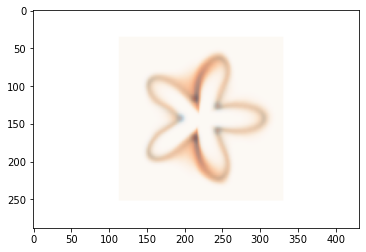

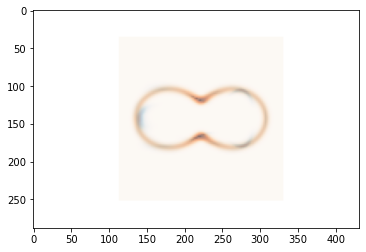

In [28]:
plt.imshow(img_target2_warp)
plt.show()
plt.imshow(img_source2_warp)



In [6]:
import monai
from monai.networks.nets.unet import UNet
depth = 5; maxch = 64
channels = (8,16,32,64,64,64)
strides = (2,2,1,2,1)
if(depth==4):
    strides = (2,2,1,2)
    channels = (8,16,32,64,64)
if(depth==3):
    strides = (2,2,2)
    channels = (8,16,32,64)
channels = tuple([min(c,maxch) for c in channels])


In [7]:
from tqdm.notebook import trange
def reg_net_divroc(pts_fix,pts_mov,unets,sym=True):
    optimizers = []
    for i in range(len(unets)):
        optimizers.append(torch.optim.Adam(unets[i].parameters(), lr=0.015))

    kernel = 3; half_width = (kernel-1)//2
    avg5_ = nn.AvgPool2d((kernel,kernel),stride=(2,2),padding=(half_width,half_width))
    avg5 = nn.AvgPool2d((kernel,kernel),stride=(1,1),padding=(half_width,half_width))
    for iter in trange(500):
        idx = torch.randperm(256-64)[:8]+64
        if(iter==499):
            idx = torch.arange(64)

            #idx = torch.arange(8)
        pts_fix1 = pts_fix[idx].data.clone()
        pts_mov1 = pts_mov[idx].data.clone()
        for i in range(len(unets)):
            optimizers[i].zero_grad()
            with torch.no_grad():
                fixed = divroc(pts_fix1).data
                moving = divroc(pts_mov1).data
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                output_fwd = torch.tanh(unets[i](torch.cat((fixed,moving),1)))*.15#25
                output_bwd = torch.tanh(unets[i](torch.cat((moving,fixed),1)))*.15#25
            if(sym):
                field_fwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_fwd-output_bwd)))),size=(H,W),mode='bilinear').float()
            else:
                field_fwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_fwd)))),size=(H,W),mode='bilinear').float()

            smooth_hr = disp_square(field_fwd)
            warped = divroc(pts_mov1,smooth_hr)
            loss = nn.L1Loss()(fixed,warped)

            if(sym):
                field_bwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_bwd-output_fwd)))),size=(H,W),mode='bilinear').float()
            else:
                field_bwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_bwd)))),size=(H,W),mode='bilinear').float()

            smooth_hr = disp_square(field_bwd)
            warped = divroc(pts_fix1,smooth_hr)
            #if(sym):
            loss += nn.L1Loss()(moving,warped)

            loss.backward()
            optimizers[i].step()
        
            pts_mov1 = divroc_add(pts_mov1.data.clone(),disp_square(field_fwd/2)).data
            pts_fix1 = divroc_add(pts_fix1.data.clone(),disp_square(field_bwd/2)).data
            if((iter==499)&(i==0)):
                field_fwd_1st = field_fwd.data.clone()
                field_bwd_1st = field_bwd.data.clone()
                
    return field_fwd_1st.data,field_bwd_1st.data,field_fwd.data,field_bwd.data

In [8]:

def reg_net_warp(fixed,moving,unets,sym=True):
    optimizers = []
    for i in range(len(unets)):
        optimizers.append(torch.optim.Adam(unets[i].parameters(), lr=0.015))
    grid0 = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda().repeat(8,1,1),(8,1,H,W),align_corners=False)
    kernel = 3; half_width = (kernel-1)//2
    avg5_ = nn.AvgPool2d((kernel,kernel),stride=(2,2),padding=(half_width,half_width))
    avg5 = nn.AvgPool2d((kernel,kernel),stride=(1,1),padding=(half_width,half_width))
    for iter in trange(500):
        idx = torch.randperm(256-64)[:8]+64
        if(iter==499):
            idx = torch.arange(64)
            grid0 = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda().repeat(64,1,1),(64,1,H,W),align_corners=False)

        fixed1 = fixed[idx].data.clone()
        moving1 = moving[idx].data.clone()
        for i in range(len(unets)):
            optimizers[i].zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                output_fwd = torch.tanh(unets[i](torch.cat((fixed1,moving1),1)))*.15#25
                output_bwd = torch.tanh(unets[i](torch.cat((moving1,fixed1),1)))*.15#25
            if(sym):
                field_fwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_fwd-output_bwd)))),size=(H,W),mode='bilinear').float()
            else:
                field_fwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_fwd)))),size=(H,W),mode='bilinear').float()
            
            smooth_hr = disp_square(field_fwd)
            warped = F.grid_sample(moving1,smooth_hr.permute(0,2,3,1)+grid0,align_corners=False)
            loss = nn.L1Loss()(fixed1,warped)

            if(sym):
                field_bwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_bwd-output_fwd)))),size=(H,W),mode='bilinear').float()
            else:
                field_bwd = F.interpolate(avg5(avg5(avg5_(avg5_(output_bwd)))),size=(H,W),mode='bilinear').float()

            smooth_hr = disp_square(field_bwd)
            warped = F.grid_sample(fixed1,smooth_hr.permute(0,2,3,1)+grid0,align_corners=False)
            #if(sym):
            loss += nn.L1Loss()(moving1,warped)

            loss.backward()
            optimizers[i].step()
        
            #midstep warp
            moving1 = F.grid_sample(moving[idx].data.clone(),disp_square(field_fwd/2).permute(0,2,3,1)+grid0,align_corners=False).data
            fixed1 = F.grid_sample(fixed[idx].data.clone(),disp_square(field_bwd/2).permute(0,2,3,1)+grid0,align_corners=False).data

            #pts_mov1 = divroc_add(pts_mov1.data.clone(),disp_square(field_fwd/2)).data
            #pts_fix1 = divroc_add(pts_fix1.data.clone(),disp_square(field_bwd/2)).data
            if((iter==499)&(i==0)):
                field_fwd_1st = field_fwd.data.clone()
                field_bwd_1st = field_bwd.data.clone()
                
    return field_fwd_1st.data,field_bwd_1st.data,field_fwd.data,field_bwd.data

#twostep_fwd = compose(compose(disp_square(wfield1_fwd/2),disp_square(wfield2_fwd)),disp_square(wfield1_fwd/2))
#twostep_bwd = compose(compose(disp_square(wfield1_bwd/2),disp_square(wfield2_bwd)),disp_square(wfield1_bwd/2))
#norm_ice = visualise(torch.arange(1),twostep_fwd[:1],twostep_bwd[:1])#,source2_warp,target2_warp)


In [31]:
sets = []
for i in range(2,7):
    for j in range(3,7):
        if(i<j):
            sets.append((i,j))
#sets = sets[2:3]
len(sets)

10

In [75]:
dmap_errs_before = []

for run,ij in enumerate(sets):

    dmaps_tgt,dmaps_src,target0,source0,pts_tgt,pts_src = create_data(int(ij[0]),int(ij[1]))

    dmap_err1_ = F.grid_sample(dmaps_tgt[:64],(pts_src[:64].data.clone()).data).squeeze()#.mean(1)
    dmap_err2_ = F.grid_sample(dmaps_src[:64],(pts_tgt[:64].data.clone()).data).squeeze()#.mean(1)
    dmap_errs_before.append(dmap_err1_); dmap_errs_before.append(dmap_err2_)
    

  0%|          | 0/384 [00:00<?, ?it/s]

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

#0 set: 2 3


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.


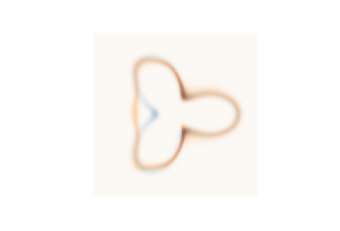

divroc HD95 tensor(0.5135) divroc errors tensor(0.0156)


  0%|          | 0/500 [00:00<?, ?it/s]

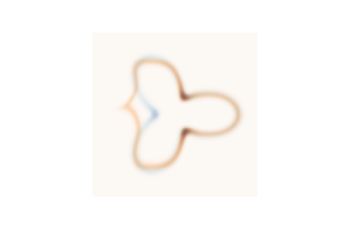

warp HD95 tensor(0.5390) warp errors tensor(0.0156)
#1 set: 2 4


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

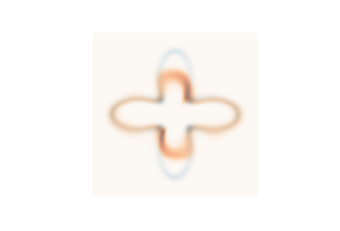

divroc HD95 tensor(0.6768) divroc errors tensor(0.1172)


  0%|          | 0/500 [00:00<?, ?it/s]

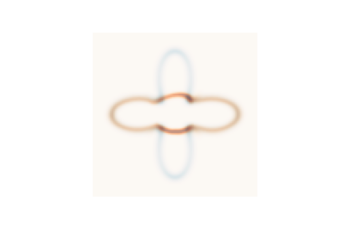

warp HD95 tensor(1.1102) warp errors tensor(0.1797)
#2 set: 2 5


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

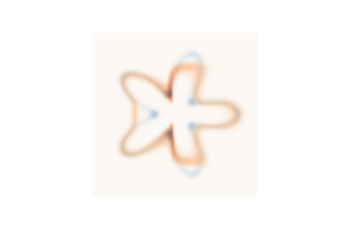

divroc HD95 tensor(0.5118) divroc errors tensor(0.0234)


  0%|          | 0/500 [00:00<?, ?it/s]

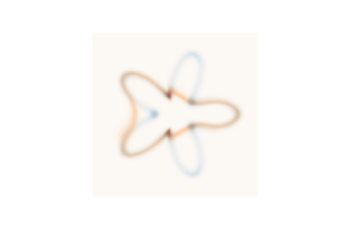

warp HD95 tensor(1.1951) warp errors tensor(0.2188)
#3 set: 2 6


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

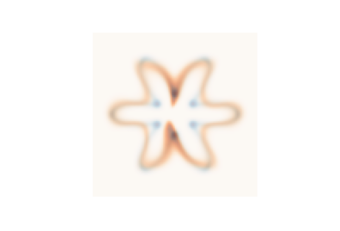

divroc HD95 tensor(0.5469) divroc errors tensor(0.0156)


  0%|          | 0/500 [00:00<?, ?it/s]

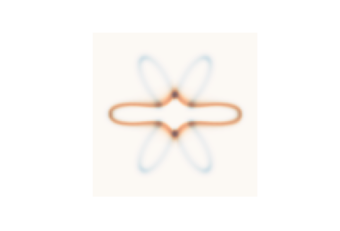

warp HD95 tensor(1.1134) warp errors tensor(0.1953)
#4 set: 3 4


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

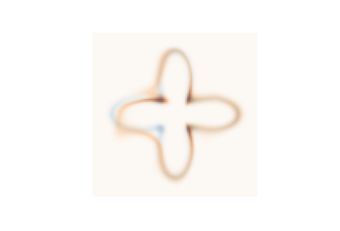

divroc HD95 tensor(0.5028) divroc errors tensor(0.0078)


  0%|          | 0/500 [00:00<?, ?it/s]

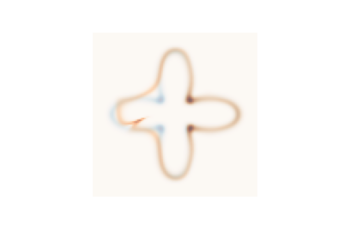

warp HD95 tensor(0.5839) warp errors tensor(0.0391)
#5 set: 3 5


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

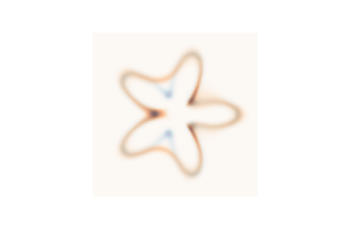

divroc HD95 tensor(0.5583) divroc errors tensor(0.0625)


  0%|          | 0/500 [00:00<?, ?it/s]

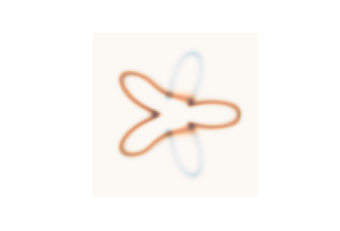

warp HD95 tensor(0.9661) warp errors tensor(0.1406)
#6 set: 3 6


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

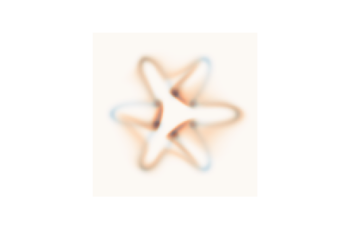

divroc HD95 tensor(0.5973) divroc errors tensor(0.0469)


  0%|          | 0/500 [00:00<?, ?it/s]

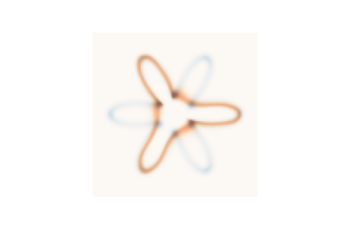

warp HD95 tensor(1.3275) warp errors tensor(0.4453)
#7 set: 4 5


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

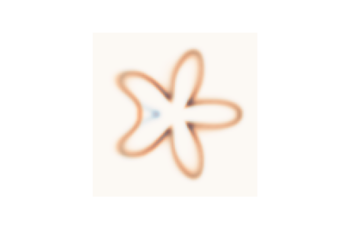

divroc HD95 tensor(0.5773) divroc errors tensor(0.0391)


  0%|          | 0/500 [00:00<?, ?it/s]

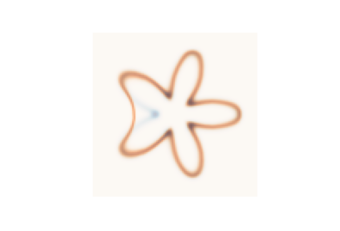

warp HD95 tensor(0.9849) warp errors tensor(0.1797)
#8 set: 4 6


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

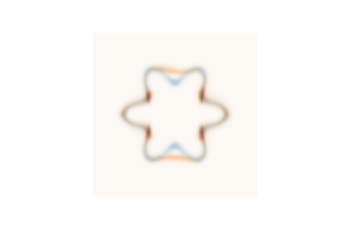

divroc HD95 tensor(0.7978) divroc errors tensor(0.1562)


  0%|          | 0/500 [00:00<?, ?it/s]

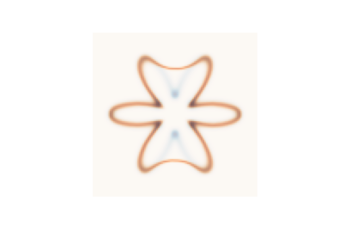

warp HD95 tensor(1.2742) warp errors tensor(0.2578)
#9 set: 5 6


  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

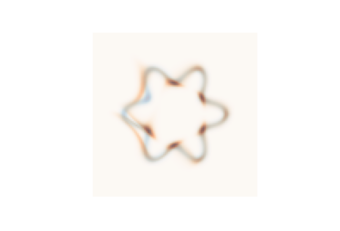

divroc HD95 tensor(0.8982) divroc errors tensor(0.5156)


  0%|          | 0/500 [00:00<?, ?it/s]

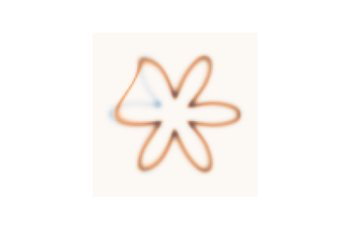

warp HD95 tensor(1.4299) warp errors tensor(0.3203)


In [77]:
hd95_err_divroc1 = torch.zeros(10,2)
dmap_errs_divroc1 = []
visual_divroc1 = []
hd95_err_warp1 = torch.zeros(10,2)
dmap_errs_warp1 = []
visual_warp1 = []
for run,ij in enumerate(sets):

    print('#'+str(run)+' set:',int(ij[0]),int(ij[1]))
    dmaps_tgt,dmaps_src,target0,source0,pts_tgt,pts_src = create_data(int(ij[0]),int(ij[1]))
    #initialise UNets
    plt.imshow(target0[0,0].data.cpu(),'Blues')
    plt.imshow(source0[0,0].data.cpu(),'Oranges',alpha=.5)
    plt.axis('off')
    plt.savefig('petal_set_'+str(ij[0])+'_'+str(ij[1])+'_init.png')
    plt.close()
    unet1 = [];
    for i in range(1):
        unet1.append(UNet(spatial_dims=2,in_channels=2,out_channels=2,channels=channels,strides=strides).to(device))
    sym = True#False#True
    field1_fwd,field1_bwd,field2_fwd,field2_bwd = reg_net_divroc(pts_tgt.data.clone(),pts_src.data.clone(),unet1,sym=sym) 

    with torch.no_grad():
        if((len(unet1)==2)):
            twostep_fwd = compose(compose(disp_square(field1_fwd/2),disp_square(field2_fwd)),disp_square(field1_fwd/2))
            twostep_bwd = compose(compose(disp_square(field1_bwd/2),disp_square(field2_bwd)),disp_square(field1_bwd/2))
        else:
            twostep_fwd = disp_square(field1_fwd)
            twostep_bwd = disp_square(field1_bwd)

        source2_warp = divroc(pts_src[:64].data.clone(),twostep_fwd[:64])
        target2_warp = divroc(pts_tgt[:64].data.clone(),twostep_bwd[:64])
    dmap_err1_ = F.grid_sample(dmaps_tgt[:64],divroc_add(pts_src[:64].data.clone(),twostep_fwd).data).squeeze()#.mean(1)
    dmap_err2_ = F.grid_sample(dmaps_src[:64],divroc_add(pts_tgt[:64].data.clone(),twostep_bwd).data).squeeze()#.mean(1)
    dmap_errs_divroc1.append(dmap_err1_); dmap_errs_divroc1.append(dmap_err2_)
    dmap_err1 = dmap_err1_.quantile(.95,dim=1)
    dmap_err2 = dmap_err2_.quantile(.95,dim=1)
    hd95_err_divroc1[run,0] = .5*(dmap_err1.mean()+dmap_err2.mean())
    hd95_err_divroc1[run,1] = ((dmap_err1>.8).sum()+(dmap_err2>0.8).sum())/(2*dmap_err1.numel())

    top1 = torch.topk(dmap_err1+dmap_err2,k=1).indices[-1:]
    top5 = torch.topk(dmap_err1+dmap_err2,k=5).indices[-1:]

    img5_divroc = visualise(top5,twostep_fwd[top5],twostep_bwd[top5])
    visual_divroc1.append(img5_divroc)
    img1_divroc = visualise(top1,twostep_fwd[top1],twostep_bwd[top1])
    visual_divroc1.append(img1_divroc)
    plt.imshow(img1_divroc[0]); plt.axis('off'); plt.show()
    print('divroc HD95',hd95_err_divroc[run,0],'divroc errors',hd95_err_divroc[run,1])
    #norm_ice = visualise(torch.arange(1),twostep_fwd[:1],twostep_bwd[:1])#,source2_warp,target2_warp)
    
    
    
    unet1 = [];
    for i in range(1):
        unet1.append(UNet(spatial_dims=2,in_channels=2,out_channels=2,channels=channels,strides=strides).to(device))
    sym = True#False
    wfield1_fwd,wfield1_bwd,wfield2_fwd,wfield2_bwd = reg_net_warp(source0,target0,unet1,sym=sym) 
    #field1_fwd,field1_bwd,field2_fwd,field2_bwd = reg_net_divroc(pts_tgt.data.clone(),pts_src.data.clone(),unet1) 
    with torch.no_grad():
        if(len(unet1)==2):

            twostep_fwd = compose(compose(disp_square(wfield1_fwd/2),disp_square(wfield2_fwd)),disp_square(wfield1_fwd/2))
            twostep_bwd = compose(compose(disp_square(wfield1_bwd/2),disp_square(wfield2_bwd)),disp_square(wfield1_bwd/2))
        else:
            twostep_fwd = disp_square(wfield1_fwd)
            twostep_bwd = disp_square(wfield1_bwd)

    dmap_err1_ = F.grid_sample(dmaps_tgt[:64],divroc_add(pts_src[:64].data.clone(),twostep_fwd).data).squeeze()#.mean(1)
    dmap_err2_ = F.grid_sample(dmaps_src[:64],divroc_add(pts_tgt[:64].data.clone(),twostep_bwd).data).squeeze()#.mean(1)
    dmap_errs_warp1.append(dmap_err1_); dmap_errs_warp1.append(dmap_err2_)
    
    #unet1 = [];
    #for i in range(2):
    #    unet1.append(UNet(spatial_dims=2,in_channels=2,out_channels=2,channels=channels,strides=strides).to(device))
    dmap_err1 = dmap_err1_.quantile(.95,dim=1)
    dmap_err2 = dmap_err2_.quantile(.95,dim=1)
   
    hd95_err_warp1[run,0] = .5*(dmap_err1.mean()+dmap_err2.mean())
    hd95_err_warp1[run,1] = ((dmap_err1>.8).sum()+(dmap_err2>0.8).sum())/(2*dmap_err1.numel())

    top1 = torch.topk(dmap_err1+dmap_err2,k=1).indices[-1:]
    top5 = torch.topk(dmap_err1+dmap_err2,k=5).indices[-1:]

    img5_warp = visualise(top5,twostep_fwd[top5],twostep_bwd[top5])
    visual_warp1.append(img5_warp)
    img1_warp = visualise(top1,twostep_fwd[top1],twostep_bwd[top1])
    visual_warp1.append(img1_warp)
    plt.imshow(img1_warp[0]); plt.axis('off'); plt.show()
    
    print('warp HD95',hd95_err_warp[run,0],'warp errors',hd95_err_warp[run,1])
    

In [72]:
import matplotlib
tab10 = matplotlib.cm.get_cmap('tab10')
 

In [90]:
from matplotlib import cm
cmap = (cm.get_cmap('tab10')(np.linspace(0,1,10)))
from matplotlib import font_manager

font_path = 'Montserrat/MontserratMedium-lgZ6e.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['font.size'] = 16


<Figure size 432x288 with 0 Axes>

'MontserratMedium-lgZ6e.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


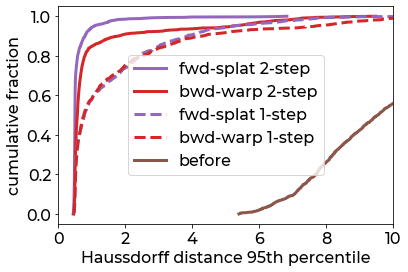

In [91]:
plt.plot(torch.stack(dmap_errs_divroc).quantile(.95,dim=-1).reshape(-1).sort().values.data.cpu(),torch.linspace(0,1,1280),color=tab10(4),linewidth=3,label='fwd-splat 2-step')
plt.plot(torch.stack(dmap_errs_warp).quantile(.95,dim=-1).reshape(-1).sort().values.data.cpu(),torch.linspace(0,1,1280),linewidth=3,color=tab10(3),label='bwd-warp 2-step')
plt.plot(torch.stack(dmap_errs_divroc1).quantile(.95,dim=-1).reshape(-1).sort().values.data.cpu(),torch.linspace(0,1,1280),'--',color=tab10(4),linewidth=3,label='fwd-splat 1-step')
plt.plot(torch.stack(dmap_errs_warp1).quantile(.95,dim=-1).reshape(-1).sort().values.data.cpu(),torch.linspace(0,1,1280),'--',linewidth=3,color=tab10(3),label='bwd-warp 1-step')
plt.plot(torch.stack(dmap_errs_before).quantile(.95,dim=-1).reshape(-1).sort().values.data.cpu(),torch.linspace(0,1,1280),linewidth=3,color=tab10(5),label='before')
plt.legend()
plt.xlabel('Haussdorff distance 95th percentile')
plt.xlim(0,10)
plt.ylabel('cumulative fraction')
plt.savefig('cumulative_hd95_petal.pdf')
plt.show()

In [36]:
hd95_err_warp.mean(0)

tensor([1.0489, 0.1937])

In [37]:
hd95_err_divroc.mean(0)

tensor([0.6317, 0.1109])

In [45]:
plt.plot()

(288, 432, 4)

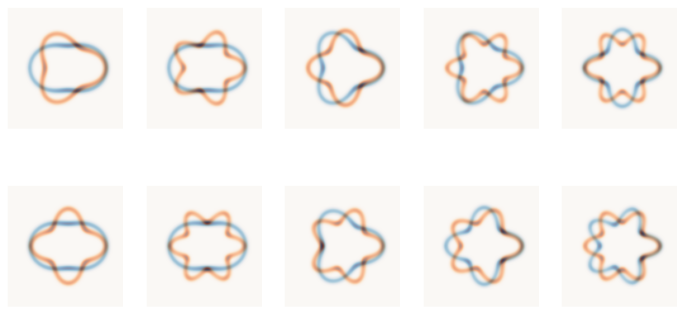

In [46]:
import imageio.v3 as iio
f,ax = plt.subplots(2,5,figsize=(12,6))
for i in range(10):
    ij = sets[i]
    img = iio.imread('petal_set_'+str(ij[0])+'_'+str(ij[1])+'_init.png')
    ax[i%2][i//2].imshow(img[32:-32,112:-112])
    ax[i%2][i//2].axis('off')
plt.show()

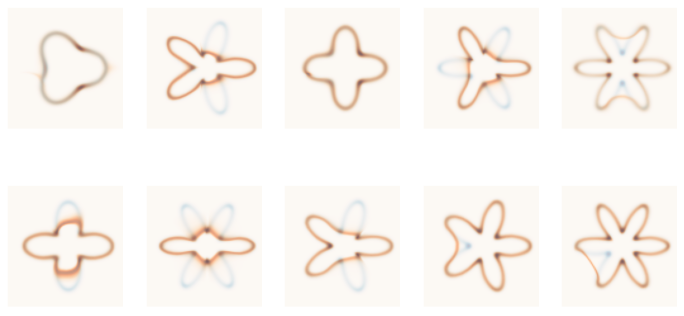

In [47]:
f,ax = plt.subplots(2,5,figsize=(12,6))
for i in range(10):
    ax[i%2][i//2].imshow(visual_warp[i*2][0][32:-32,112:-112])
    ax[i%2][i//2].axis('off')
plt.show()

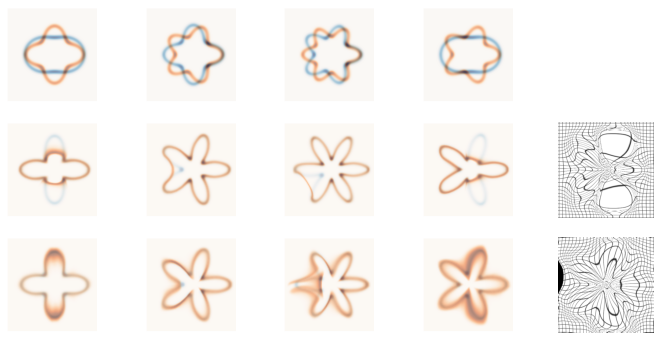

In [94]:
f,ax = plt.subplots(3,5,figsize=(12,6))
for ii,i in enumerate((1,7,9,2,)):
    ij = sets[i]
    img = iio.imread('petal_set_'+str(ij[0])+'_'+str(ij[1])+'_init.png')
    ax[0][ii].imshow(img[32:-32,112:-112])
    ax[0][ii].axis('off')
    ax[1][ii].imshow(visual_warp[i*2][0][32:-32,112:-112])
    ax[1][ii].axis('off')
    ax[2][ii].imshow(visual_divroc[i*2][0][32:-32,112:-112])
    ax[2][ii].axis('off')
ax[1][4].imshow(visual_warp[2*2][3],'gray')
ax[1][4].axis('off')
ax[2][4].imshow(visual_divroc[2*2][3],'gray')
ax[2][4].axis('off')
ax[0][4].imshow(torch.ones(128,128,3))
ax[0][4].axis('off')
plt.savefig('petal_all.png')
plt.show()

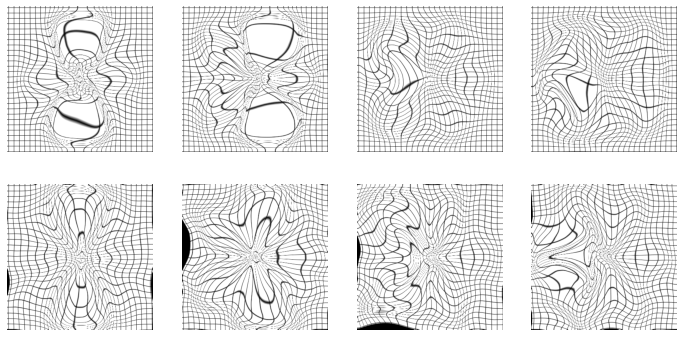

In [70]:
f,ax = plt.subplots(2,4,figsize=(12,6))
for ii,i in enumerate((1,2,7,9)):
    ij = sets[i]
    img = iio.imread('petal_set_'+str(ij[0])+'_'+str(ij[1])+'_init.png')
    ax[0][ii].imshow(visual_warp[i*2][3],'gray')
    ax[0][ii].axis('off')
    ax[1][ii].imshow(visual_divroc[i*2][3],'gray')
    ax[1][ii].axis('off')
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

mean tensor([0.3878, 0.3785, 0.4557, 0.4167, 2.0389, 1.9909, 0.4181, 0.3864, 2.3515,
        0.4205, 0.4300, 0.4172, 0.3892, 0.4280, 0.3922, 0.4509, 0.4358, 1.9006,
        2.0489, 0.3738, 0.3953, 0.3610, 0.3685, 0.3812, 0.4041, 0.4299, 0.4617,
        0.4454, 0.4256, 0.4041, 0.4231, 0.8476, 0.3770, 0.4189, 0.3950, 0.4460,
        0.3893, 1.5765, 0.4514, 0.4040, 0.3949, 0.4361, 0.4106, 0.4177, 0.3991,
        0.5374, 0.3960, 0.3839, 0.4050, 2.1026, 0.4047, 1.8022, 0.3908, 2.1415,
        0.4676, 0.3969, 0.4227, 0.4554, 0.4073, 0.3748, 0.4164, 0.4114, 2.0716,
        0.4298], device='cuda:0') tensor(0.6687, device='cuda:0')
mean tensor([0.3809, 0.3607, 0.4369, 0.4204, 0.6389, 0.6441, 0.4208, 0.3721, 0.7757,
        0.4219, 0.4296, 0.4303, 0.3833, 0.4248, 0.3704, 0.4422, 0.4064, 0.6037,
        0.6547, 0.3738, 0.3892, 0.3598, 0.3933, 0.3764, 0.3610, 0.4405, 0.4505,
        0.4340, 0.3978, 0.3790, 0.4461, 0.5960, 0.3626, 0.3989, 0.3925, 0.4016,
        0.4047, 0.6376, 0.4387, 0.3897, 0.41

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
